In [2]:
import pandas as pd
import numpy as np

# 1.data loading
flights = pd.read_excel("Airlines.xlsx")
airports = pd.read_excel("airports.xlsx")
runways = pd.read_excel("runways.xlsx")

In [3]:
# 2. Data Cleaning - Standardize Identifiers

for c in ["AirportFrom", "AirportTo"]:
    flights[c] = flights[c].astype(str).str.strip().str.upper()

for c in ["ident", "iata_code", "gps_code", "local_code"]:
    airports[c] = airports[c].astype(str).str.strip().str.upper()

for c in ["airport_ident", "surface"]:
    runways[c] = runways[c].astype(str).str.strip().str.upper()

In [4]:
# 3. Runway Aggregation

# columns we want to use from '[runways]' table
rw = runways[["airport_ident","length_ft","width_ft","surface","lighted","closed"]].copy()

# Convert numeric fields, coercing errors to NaN
for c in ["length_ft", "width_ft", "lighted", "closed"]:
    rw[c] = pd.to_numeric(rw[c], errors="coerce")

# build a function for mode for 'surface' column
mode_or_nan = lambda s: s.mode().iat[0] if not s.dropna().empty else np.nan #we get the mode

#  Aggregate runway data by airport
rw_agg = (
    rw.groupby("airport_ident")
      .agg(
          num_runways       = ("length_ft", "count"),     # runway number
          max_runway_len_ft = ("length_ft", "max"),      # max length 
          avg_runway_len_ft = ("length_ft", "mean"),     # mean length
          avg_runway_wid_ft = ("width_ft", "mean"),      # mean width
          has_lighted       = ("lighted", "max"),        # max number light
          num_closed        = ("closed", "sum"),         # number closed
          main_surface      = ("surface", mode_or_nan),  # surface material
      )
      .reset_index()
)

# Create binary indicator for closed runways
rw_agg["has_closed"] = (rw_agg["num_closed"] > 0).astype(int)

print(rw_agg.columns)

Index(['airport_ident', 'num_runways', 'max_runway_len_ft',
       'avg_runway_len_ft', 'avg_runway_wid_ft', 'has_lighted', 'num_closed',
       'main_surface', 'has_closed'],
      dtype='object')


In [5]:
# columns we want to use from '[runways]' table
rw = runways[["airport_ident","length_ft","width_ft","surface","lighted","closed"]].copy()

# change all values to numeric and for unknown value, we use NaN
for c in ["length_ft", "width_ft", "lighted", "closed"]:
    rw[c] = pd.to_numeric(rw[c], errors="coerce")

# build a function for mode for 'surface' column
mode_or_nan = lambda s: s.mode().iat[0] if not s.dropna().empty else np.nan #we get the mode

# build a groupby for [runways]
rw_agg = (
    rw.groupby("airport_ident")
      .agg(
          num_runways       = ("length_ft", "size"),     # runway number
          max_runway_len_ft = ("length_ft", "max"),      # max length 
          avg_runway_len_ft = ("length_ft", "mean"),     # mean length
          avg_runway_wid_ft = ("width_ft", "mean"),      # mean width
          has_lighted       = ("lighted", "max"),        # max number light
          num_closed        = ("closed", "sum"),         # number closed
          main_surface      = ("surface", mode_or_nan),  # surface material
      )
      .reset_index()
)

# whether any runway is closed
rw_agg["has_closed"] = (rw_agg["num_closed"] > 0).astype(int)

print(rw_agg.columns)

Index(['airport_ident', 'num_runways', 'max_runway_len_ft',
       'avg_runway_len_ft', 'avg_runway_wid_ft', 'has_lighted', 'num_closed',
       'main_surface', 'has_closed'],
      dtype='object')


In [6]:
rw_agg.head()  ## new runways table

,airport_ident,num_runways,max_runway_len_ft,avg_runway_len_ft,avg_runway_wid_ft,has_lighted,num_closed,main_surface,has_closed
0,0,2,3270.0,3135.0,90.0,0,0,TURF-F,0
1,00A,1,80.0,80.0,80.0,1,0,ASPH-G,0
2,00AK,1,2500.0,2500.0,70.0,0,0,GRVL,0
3,00AL,1,2300.0,2300.0,200.0,0,0,TURF,0
4,00AR,1,40.0,40.0,40.0,0,0,GRASS,0


In [7]:
# 4. Airport-Runway Integration

# Create enriched airport dataset

air = airports.copy()

# Merge runway aggregations

air = air.merge(
    rw_agg,
    left_on="ident",
    right_on="airport_ident",
    how="left"
).drop(columns=["airport_ident"])


# Validation check: identify airports without runway data

airports_without_runways = air[air['num_runways'].isna()]
print(f"Warning: {len(airports_without_runways)} airports have no runway data")


columns_new = [
    "ident", "name", "type",   # airport information
    "latitude_deg", "longitude_deg", "elevation_ft",  # geography information
    "iso_country", "iso_region", "municipality",      # state, region, city

    # runways 
    "num_runways", "max_runway_len_ft", "avg_runway_len_ft",
    "avg_runway_wid_ft", "has_lighted", "num_closed", "has_closed",
    "main_surface",

    # judt used for combining 
    "iata_code", "gps_code", "local_code"
]

air_use = air[columns_new].copy()

print(air_use.columns)


Index(['ident', 'name', 'type', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'iso_country', 'iso_region', 'municipality',
       'num_runways', 'max_runway_len_ft', 'avg_runway_len_ft',
       'avg_runway_wid_ft', 'has_lighted', 'num_closed', 'has_closed',
       'main_surface', 'iata_code', 'gps_code', 'local_code'],
      dtype='object')


In [8]:
air_use.head()  # airport + runways table


,ident,name,type,latitude_deg,longitude_deg,elevation_ft,iso_country,iso_region,municipality,num_runways,max_runway_len_ft,avg_runway_len_ft,avg_runway_wid_ft,has_lighted,num_closed,has_closed,main_surface,iata_code,gps_code,local_code
0,00A,Total Rf Heliport,heliport,40.070801,-74.933601,11.0,US,US-PA,Bensalem,1.0,80.0,80.0,80.0,1.0,0.0,0.0,ASPH-G,NAN,00A,00A
1,00AA,Aero B Ranch Airport,small_airport,38.704022,-101.473911,3435.0,US,US-KS,Leoti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NAN,00AA,00AA
2,00AK,Lowell Field,small_airport,59.947733,-151.692524,450.0,US,US-AK,Anchor Point,1.0,2500.0,2500.0,70.0,0.0,0.0,0.0,GRVL,NAN,00AK,00AK
3,00AL,Epps Airpark,small_airport,34.864799,-86.770302,820.0,US,US-AL,Harvest,1.0,2300.0,2300.0,200.0,0.0,0.0,0.0,TURF,NAN,00AL,00AL
4,00AR,Newport Hospital & Clinic Heliport,closed,35.608700,-91.254898,237.0,US,US-AR,Newport,1.0,40.0,40.0,40.0,0.0,0.0,0.0,GRASS,NAN,NAN,NAN


In [9]:
fl = flights.merge(
    air_use.add_suffix("_from"),          
    left_on="AirportFrom",                
    right_on="iata_code_from",            
    how="left"
)

fl = fl.merge(
    air_use.add_suffix("_to"),
    left_on="AirportTo",
    right_on="iata_code_to",
    how="left"
)

print(fl.shape)
fl.head()

(518556, 49)


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,ident_from,...,max_runway_len_ft_to,avg_runway_len_ft_to,avg_runway_wid_ft_to,has_lighted_to,num_closed_to,has_closed_to,main_surface_to,iata_code_to,gps_code_to,local_code_to
0,1,CO,269,SFO,IAH,3,15,205,1,KSFO,...,12001.0,10080.400000,150.000000,1.0,0.0,0.0,CON,IAH,KIAH,IAH
1,2,US,1558,PHX,CLT,3,15,222,1,KPHX,...,10000.0,9044.500000,150.000000,1.0,0.0,0.0,PEM,CLT,KCLT,CLT
2,3,AA,2400,LAX,DFW,3,20,165,1,KLAX,...,13401.0,11486.142857,171.428571,1.0,0.0,0.0,CON,DFW,KDFW,DFW
3,4,AA,2466,SFO,DFW,3,20,195,1,KSFO,...,13401.0,11486.142857,171.428571,1.0,0.0,0.0,CON,DFW,KDFW,DFW
4,5,AS,108,ANC,SEA,3,30,202,0,PANC,...,11900.0,10250.666667,150.000000,1.0,1.0,1.0,ASP,SEA,KSEA,SEA


In [10]:
print(fl.columns)

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'ident_from', 'name_from', 'type_from',
       'latitude_deg_from', 'longitude_deg_from', 'elevation_ft_from',
       'iso_country_from', 'iso_region_from', 'municipality_from',
       'num_runways_from', 'max_runway_len_ft_from', 'avg_runway_len_ft_from',
       'avg_runway_wid_ft_from', 'has_lighted_from', 'num_closed_from',
       'has_closed_from', 'main_surface_from', 'iata_code_from',
       'gps_code_from', 'local_code_from', 'ident_to', 'name_to', 'type_to',
       'latitude_deg_to', 'longitude_deg_to', 'elevation_ft_to',
       'iso_country_to', 'iso_region_to', 'municipality_to', 'num_runways_to',
       'max_runway_len_ft_to', 'avg_runway_len_ft_to', 'avg_runway_wid_ft_to',
       'has_lighted_to', 'num_closed_to', 'has_closed_to', 'main_surface_to',
       'iata_code_to', 'gps_code_to', 'local_code_to'],
      dtype='object')


In [11]:
# airline found year and operation years

In [12]:
# get data on line

In [13]:
import requests
import pandas as pd
import io


url = "https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States"

# hide as web
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/122.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)
response.raise_for_status()

# read all tables
#tables = pd.read_html(response.text)

tables = pd.read_html(io.StringIO(response.text))

#print(f"wike has in total {len(tables)} tables")

# for all list
airlines2_list = []
for t in tables:
    cols = t.columns
    # whether include the line we want
    needed = {"Airline", "IATA", "Founded"}
    if needed.issubset(set(cols)):
        airlines2_list.append(t[["Airline", "IATA", "Founded"]])

# combine all tables
 
airlines2_df = pd.concat(airlines2_list, ignore_index=True)

# data cleaning
airlines2_df["Founded"] = pd.to_numeric(airlines2_df["Founded"], errors="coerce")  # to integer
airlines2_df["Founded"] = airlines2_df["Founded"].astype("Int64")  # transfer to an integer
airlines2_df = airlines2_df.dropna(subset=['IATA', 'Founded']) #delete NA

airlines2_df = airlines2_df.drop_duplicates(subset=['IATA'], keep='first') #delete duplicate

print(airlines2_df.head(10))
  

              Airline IATA  Founded
0     Alaska Airlines   AS     1932
1       Allegiant Air   G4     1997
2   American Airlines   AA     1926
3      Avelo Airlines   XP     1987
4      Breeze Airways   MX     2018
5     Delta Air Lines   DL     1924
6   Frontier Airlines   F9     1994
7   Hawaiian Airlines   HA     1929
8             JetBlue   B6     1998
9  Southwest Airlines   WN     1967


In [14]:
print(f"successfully found {len(airlines2_df)} records")

successfully found 87 records


In [15]:
# check whether each IATA has united Founded years 
dup_check = airlines2_df.groupby("IATA")["Founded"].nunique()

# 
conflict = dup_check[dup_check > 1]
print(conflict)



Series([], Name: Founded, dtype: int64)


In [16]:
# 
air_year = airlines2_df[['IATA', 'Founded']].rename(columns={'Founded': 'airline_founded_year'})

# merge
fl2 = fl.merge(
    air_year,
    left_on='Airline',   # flights:
    right_on='IATA',     # wiki 
    how='left'
).drop(columns=['IATA'])

# 
#print('before:', fl.shape, 'after:', fl2.shape)

# calculate how many years operated
REF_YEAR = 2025
fl2['airline_age'] = (REF_YEAR - fl2['airline_founded_year']).astype('Int64')


In [17]:
print(fl2.shape)

(518556, 51)


In [18]:
#final_df = fl2.copy()
#print(final_df[['Airline', 'airline_founded_year', 'airline_age']].head())

In [19]:
# 1(d)

In [20]:
import requests
import pandas as pd
import io

url = "https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States"

# hide as web
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/122.0.0.0 Safari/537.36"
}

response2 = requests.get(url, headers=headers)
response2.raise_for_status()

# read all tables
#tables = pd.read_html(response.text)

tables2 = pd.read_html(io.StringIO(response.text))

In [21]:
import requests, io
import pandas as pd
import numpy as np

# 1) wiki
url = "https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States"
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/122.0.0.0 Safari/537.36"
}

resp = requests.get(url, headers=headers)
resp.raise_for_status()

tables2 = pd.read_html(io.StringIO(resp.text))

# 2)  IATA Code  2024 data
candidates = []
for t in tables2:
    cols = [str(c).lower() for c in t.columns]
    if any("iata" in c for c in cols) and any("2024" in c for c in cols):
        candidates.append(t)

print("number of candidate tables：", len(candidates))


number of candidate tables： 4


In [22]:
for i, t in enumerate(candidates):
    print(f"table {i} column name:", t.columns.tolist())


table 0 column name: ['Rank (2024)', 'Airports (large)', 'IATA Code', 'Major cities served', 'Metro area', 'State', '2024[2]', '2023[3]', '2022[4]', '2021[5]', '2020[6]', '2019[7]', '2018[8]', '2017[9]', '2016[10]', '2015[11]']
table 1 column name: ['Rank (2023)', 'Airports (medium hubs)', 'IATA Code', 'City served', 'Metro Area', 'State', '2024[2]', '2023[3]', '2022[4]', '2021[5]', '2020[6]', '2019[7]', '2018[8]', '2017[9]', '2016[10]', '2015[11]']
table 2 column name: ['Rank', 'Airport name', 'Location', 'IATA Code', '2024[12]', '2023[13]', '2022[14]', '2021[15]', '2020[16]', '2019[17]']
table 3 column name: [('Rank', 'Rank'), ('Airport name', 'Airport name'), ('Location', 'Location'), ('IATA code', 'IATA code'), ('Cargo', 'Ibs.'), ('Cargo', '% chg. 2023/2024')]


In [23]:
# first three tables
candidates = [tables2[0], tables2[1], tables2[2]]

cleaned = []
for idx, t in enumerate(candidates):
    if idx in [0, 1]:
        year_col = "2024[2]"
    else:
        year_col = "2024[12]"
    
    tmp = t[["IATA Code", year_col]].rename(columns={
        "IATA Code": "IATA",
        year_col: "enplanements_2024"
    })

    #  Convert to numeric: remove commas and footnote markers
    tmp["enplanements_2024"] = (tmp["enplanements_2024"].astype(str)
                                .str.replace(r"[^0-9]", "", regex=True)
                                .replace("", pd.NA).astype(float))
    cleaned.append(tmp)

busy_2024 = pd.concat(cleaned, ignore_index=True)

print(busy_2024.head())
print(len(busy_2024))


  IATA  enplanements_2024
0  ATL         52511402.0
1  DFW         42351316.0
2  DEN         40012895.0
3  ORD         38575693.0
4  LAX         37760834.0
93


In [24]:
total_us = busy_2024["enplanements_2024"].sum()
print(total_us)

busy_2024["share_us"] = busy_2024["enplanements_2024"] / total_us
print(busy_2024.head())

1101002981.0
  IATA  enplanements_2024  share_us
0  ATL         52511402.0  0.047694
1  DFW         42351316.0  0.038466
2  DEN         40012895.0  0.036342
3  ORD         38575693.0  0.035037
4  LAX         37760834.0  0.034297


In [25]:
# hub 
def hub_class(p):
    if p >= 0.01:        # >= 1% 
        return "large hub"
    elif p >= 0.0025:    # 0.25% - 1%
        return "medium hub"
    else:
        return "small/other"

busy_2024["hub_class"] = busy_2024["share_us"].apply(hub_class)

hubs_df = busy_2024[["IATA", "enplanements_2024", "share_us", "hub_class"]].copy()

print(hubs_df.head())
print(hubs_df.shape)

  IATA  enplanements_2024  share_us  hub_class
0  ATL         52511402.0  0.047694  large hub
1  DFW         42351316.0  0.038466  large hub
2  DEN         40012895.0  0.036342  large hub
3  ORD         38575693.0  0.035037  large hub
4  LAX         37760834.0  0.034297  large hub
(93, 4)


In [26]:
hubs_df = hubs_df.drop_duplicates(subset=["IATA"])
print(hubs_df.shape)

(64, 4)


In [27]:
print(fl2.columns.tolist())


['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length', 'Delay', 'ident_from', 'name_from', 'type_from', 'latitude_deg_from', 'longitude_deg_from', 'elevation_ft_from', 'iso_country_from', 'iso_region_from', 'municipality_from', 'num_runways_from', 'max_runway_len_ft_from', 'avg_runway_len_ft_from', 'avg_runway_wid_ft_from', 'has_lighted_from', 'num_closed_from', 'has_closed_from', 'main_surface_from', 'iata_code_from', 'gps_code_from', 'local_code_from', 'ident_to', 'name_to', 'type_to', 'latitude_deg_to', 'longitude_deg_to', 'elevation_ft_to', 'iso_country_to', 'iso_region_to', 'municipality_to', 'num_runways_to', 'max_runway_len_ft_to', 'avg_runway_len_ft_to', 'avg_runway_wid_ft_to', 'has_lighted_to', 'num_closed_to', 'has_closed_to', 'main_surface_to', 'iata_code_to', 'gps_code_to', 'local_code_to', 'airline_founded_year', 'airline_age']


In [28]:
#print(fl2.head())

In [29]:

# hubs_df: ['IATA', 'enplanements_2024', 'share_us', 'hub_class']

fl3 = (
    fl2
    .merge(
        hubs_df.add_suffix('_from'),
        left_on='AirportFrom',      # fl2 
        right_on='IATA_from',
        how='left'
    )
    .merge(
        hubs_df.add_suffix('_to'),
        left_on='AirportTo',        # 
        right_on='IATA_to',
        how='left'
    )
    .drop(columns=['IATA_from', 'IATA_to'])  # 
)

print(fl2.shape, '→', fl3.shape)
fl3[['AirportFrom','AirportTo',
     'enplanements_2024_from','share_us_from','hub_class_from',
     'enplanements_2024_to','share_us_to','hub_class_to']].head()


(518556, 51) → (518556, 57)


,AirportFrom,AirportTo,enplanements_2024_from,share_us_from,hub_class_from,enplanements_2024_to,share_us_to,hub_class_to
0,SFO,IAH,25078968.0,0.022778,large hub,23349157.0,0.021207,large hub
1,PHX,CLT,25595723.0,0.023248,large hub,28523822.0,0.025907,large hub
2,LAX,DFW,37760834.0,0.034297,large hub,42351316.0,0.038466,large hub
3,SFO,DFW,25078968.0,0.022778,large hub,42351316.0,0.038466,large hub
4,ANC,SEA,2767856.0,0.002514,medium hub,25414592.0,0.023083,large hub


In [30]:
print(fl3.shape)

(518556, 57)


In [31]:
print(fl3.columns.tolist())


['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length', 'Delay', 'ident_from', 'name_from', 'type_from', 'latitude_deg_from', 'longitude_deg_from', 'elevation_ft_from', 'iso_country_from', 'iso_region_from', 'municipality_from', 'num_runways_from', 'max_runway_len_ft_from', 'avg_runway_len_ft_from', 'avg_runway_wid_ft_from', 'has_lighted_from', 'num_closed_from', 'has_closed_from', 'main_surface_from', 'iata_code_from', 'gps_code_from', 'local_code_from', 'ident_to', 'name_to', 'type_to', 'latitude_deg_to', 'longitude_deg_to', 'elevation_ft_to', 'iso_country_to', 'iso_region_to', 'municipality_to', 'num_runways_to', 'max_runway_len_ft_to', 'avg_runway_len_ft_to', 'avg_runway_wid_ft_to', 'has_lighted_to', 'num_closed_to', 'has_closed_to', 'main_surface_to', 'iata_code_to', 'gps_code_to', 'local_code_to', 'airline_founded_year', 'airline_age', 'enplanements_2024_from', 'share_us_from', 'hub_class_from', 'enplanements_2024_to', 'share_us_to', 'hub_class_to']

In [32]:
# q2

In [33]:

print(fl3.isna().sum())

#missing value
missing_ratio = fl3.isna().mean().sort_values(ascending=False)
print(missing_ratio)


id                            0
Airline                       0
Flight                        0
AirportFrom                   0
AirportTo                     0
DayOfWeek                     0
Time                          0
Length                        0
Delay                         0
ident_from                   31
name_from                    31
type_from                    31
latitude_deg_from            31
longitude_deg_from           31
elevation_ft_from            31
iso_country_from             31
iso_region_from              31
municipality_from            31
num_runways_from             31
max_runway_len_ft_from       31
avg_runway_len_ft_from       31
avg_runway_wid_ft_from      611
has_lighted_from             31
num_closed_from              31
has_closed_from              31
main_surface_from            31
iata_code_from               31
gps_code_from                31
local_code_from              31
ident_to                     31
name_to                      31
type_to 

In [34]:


def cols_exist(df, cols):
    return [c for c in cols if c in df.columns]

# 1) high missing
num_traffic_cols = [
    "enplanements_2024_from", "enplanements_2024_to",
    "share_us_from", "share_us_to",
]
cat_hub_cols = ["hub_class_from", "hub_class_to"]


for c in cols_exist(fl3, num_traffic_cols):
    fl3[c] = fl3[c].fillna(0).astype(float)


for c in cols_exist(fl3, cat_hub_cols):
    fl3[c] = fl3[c].fillna("Unknown")

# 2)low missing
num_low_missing = [
    "avg_runway_wid_ft_from", "avg_runway_wid_ft_to",
    "elevation_ft_from", "elevation_ft_to",
    "num_runways_from", "num_runways_to",
    "max_runway_len_ft_from", "max_runway_len_ft_to",
    "avg_runway_len_ft_from", "avg_runway_len_ft_to",
]
for c in cols_exist(fl3, num_low_missing):
    med = fl3[c].median(skipna=True)
    fl3[c] = fl3[c].fillna(med)

cat_low_missing = [
    "type_from", "type_to",
    "main_surface_from", "main_surface_to",
    "iso_country_from", "iso_country_to",
    "iso_region_from", "iso_region_to",
    "municipality_from", "municipality_to",
]
for c in cols_exist(fl3, cat_low_missing):
    fl3[c] = fl3[c].fillna("Unknown")

# 3) type
id_code_cols = [
    "ident_from", "ident_to",
    "iata_code_from", "iata_code_to",
    "gps_code_from", "gps_code_to",
    "local_code_from", "local_code_to",
    "name_from", "name_to",
]
for c in cols_exist(fl3, id_code_cols):
    fl3[c] = fl3[c].fillna("Unknown")

# 4) keep na
keep_nan_cols = ["airline_founded_year", "airline_age"]
for c in cols_exist(fl3, keep_nan_cols):

    if c == "airline_founded_year":
        fl3[c] = pd.to_numeric(fl3[c], errors="coerce").astype("Int64")
    if c == "airline_age":
        fl3[c] = pd.to_numeric(fl3[c], errors="coerce").astype("Int64")

# 5) 
missing_after = fl3.isna().sum().sort_values(ascending=False)
print("Missing values AFTER cleaning (top 20):")
print(missing_after.head(20))


Missing values AFTER cleaning (top 20):
airline_age             83601
airline_founded_year    83601
has_closed_to              31
latitude_deg_from          31
longitude_deg_to           31
has_closed_from            31
num_closed_from            31
has_lighted_from           31
has_lighted_to             31
num_closed_to              31
longitude_deg_from         31
latitude_deg_to            31
iata_code_to                0
share_us_from               0
share_us_to                 0
elevation_ft_to             0
iso_country_to              0
iso_region_to               0
municipality_to             0
enplanements_2024_to        0
dtype: int64


In [35]:


fl4 = fl3.copy()
print(fl4.shape)
print(fl4.head())


(518556, 57)
   id Airline  Flight AirportFrom AirportTo  DayOfWeek  Time  Length  Delay  \
0   1      CO     269         SFO       IAH          3    15     205      1   
1   2      US    1558         PHX       CLT          3    15     222      1   
2   3      AA    2400         LAX       DFW          3    20     165      1   
3   4      AA    2466         SFO       DFW          3    20     195      1   
4   5      AS     108         ANC       SEA          3    30     202      0   

  ident_from  ... gps_code_to local_code_to  airline_founded_year  \
0       KSFO  ...        KIAH           IAH                  <NA>   
1       KPHX  ...        KCLT           CLT                  <NA>   
2       KLAX  ...        KDFW           DFW                  1926   
3       KSFO  ...        KDFW           DFW                  1926   
4       PANC  ...        KSEA           SEA                  1932   

   airline_age  enplanements_2024_from share_us_from hub_class_from  \
0         <NA>            

In [36]:
print(fl4.columns.tolist())

['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length', 'Delay', 'ident_from', 'name_from', 'type_from', 'latitude_deg_from', 'longitude_deg_from', 'elevation_ft_from', 'iso_country_from', 'iso_region_from', 'municipality_from', 'num_runways_from', 'max_runway_len_ft_from', 'avg_runway_len_ft_from', 'avg_runway_wid_ft_from', 'has_lighted_from', 'num_closed_from', 'has_closed_from', 'main_surface_from', 'iata_code_from', 'gps_code_from', 'local_code_from', 'ident_to', 'name_to', 'type_to', 'latitude_deg_to', 'longitude_deg_to', 'elevation_ft_to', 'iso_country_to', 'iso_region_to', 'municipality_to', 'num_runways_to', 'max_runway_len_ft_to', 'avg_runway_len_ft_to', 'avg_runway_wid_ft_to', 'has_lighted_to', 'num_closed_to', 'has_closed_to', 'main_surface_to', 'iata_code_to', 'gps_code_to', 'local_code_to', 'airline_founded_year', 'airline_age', 'enplanements_2024_from', 'share_us_from', 'hub_class_from', 'enplanements_2024_to', 'share_us_to', 'hub_class_to']

In [37]:
# translate fl4 to CSV 
fl4.to_csv("fl4_data.csv", index=False, encoding="utf-8")


In [38]:
# no of each..
print(fl4['hub_class_from'].value_counts())

# percentage
print(fl4['hub_class_from'].value_counts(normalize=True) * 100)

hub_class_from
large hub      319222
medium hub     100306
Unknown         91226
small/other      7802
Name: count, dtype: int64
hub_class_from
large hub      61.559793
medium hub     19.343330
Unknown        17.592314
small/other     1.504563
Name: proportion, dtype: float64


In [39]:
# q3

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# --- my data ---
df4 = fl4.copy()   # 

# --- 1) （Delay==1 rate ---
airline_stats = (
    df4.groupby("Airline")["Delay"]
      .agg(delay_rate="mean", flights="count", delays="sum")
      .sort_values("delay_rate", ascending=False)
      .reset_index()
)
airline_stats["delay_pct"] = (airline_stats["delay_rate"] * 100).round(1)


airline_stats.head(10)


,Airline,delay_rate,flights,delays,delay_pct
0,WN,0.697759,94097,65657,69.8
1,CO,0.566199,21118,11957,56.6
2,B6,0.467038,18112,8459,46.7
3,OO,0.452899,50254,22760,45.3
4,DL,0.450476,60940,27452,45.0
5,F9,0.449040,6456,2899,44.9
6,EV,0.402208,27983,11255,40.2
7,9E,0.397660,20686,8226,39.8
8,AA,0.388470,45656,17736,38.8
9,XE,0.378944,31126,11795,37.9


Southwest (WN) — 延误率: 69.8%, 航班数: 94097, 延误数: 65657


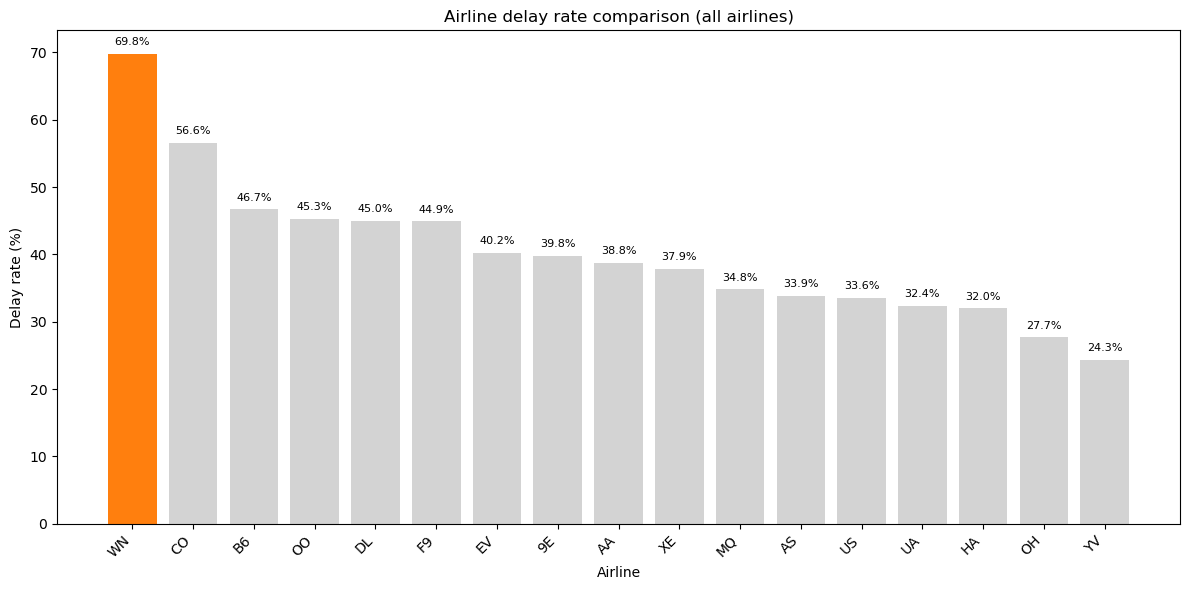

In [41]:
import pandas as pd
import matplotlib.pyplot as plt


df4 = fl4.copy()


airline_stats = (
    df4.groupby("Airline")["Delay"]
       .agg(delay_rate="mean", flights="count", delays="sum")
       .sort_values("delay_rate", ascending=False)
       .reset_index()
)
airline_stats["delay_pct"] = (airline_stats["delay_rate"] * 100).round(1)


row_wn = airline_stats.loc[airline_stats["Airline"] == "WN"].iloc[0]
wn_rate = row_wn["delay_pct"]   # 约 69.8
wn_flights = int(row_wn["flights"])
wn_delays = int(row_wn["delays"])
print(f"Southwest (WN) — 延误率: {wn_rate:.1f}%, 航班数: {wn_flights}, 延误数: {wn_delays}")


fig, ax = plt.subplots(figsize=(12, 6))


colors = ["tab:orange" if a == "WN" else "lightgray" for a in airline_stats["Airline"]]

ax.bar(airline_stats["Airline"], airline_stats["delay_pct"], color=colors)
ax.set_ylabel("Delay rate (%)")
ax.set_xlabel("Airline")
ax.set_title("Airline delay rate comparison (all airlines)")


for i, v in enumerate(airline_stats["delay_pct"]):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=8)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [42]:
# 3(b)

In [43]:

print(df4["DayOfWeek"].unique())


print(df4["DayOfWeek"].nunique())


[3 4 5 6 7 1 2]
7


In [44]:

print(df4["DayOfWeek"].value_counts().sort_index())


DayOfWeek
1    70008
2    68721
3    86478
4    87988
5    81797
6    56354
7    67210
Name: count, dtype: int64


Delay rate by day:
   day  delay_pct  flights  delays
0  Mon       47.2    70008   33059
1  Tue       45.2    68721   31072
2  Wed       47.6    86478   41144
3  Thu       45.8    87988   40280
4  Fri       42.6    81797   34813
5  Sat       40.6    56354   22860
6  Sun       45.8    67210   30761

Safest day: Sat — delay 40.6% (22,860/56,354 flights)
Worst day:  Wed — delay 47.6% (41,144/86,478 flights)


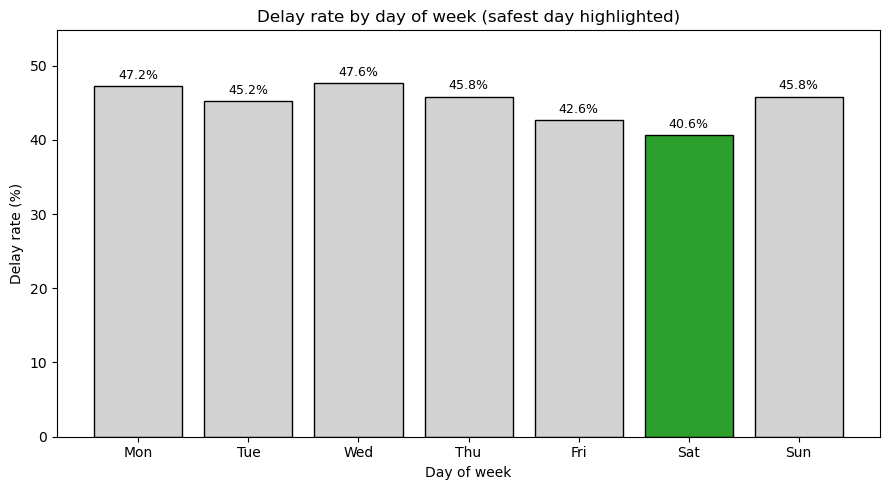

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df = fl4.copy()


df["Delay"] = pd.to_numeric(df["Delay"], errors="coerce").fillna(0).astype(int)


dow_stats = (
    df.groupby("DayOfWeek")["Delay"]
      .agg(delay_rate="mean", flights="count", delays="sum")
      .reset_index()
)


dow_stats["delay_pct"] = (dow_stats["delay_rate"] * 100).round(1)
day_names = {1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun"}
dow_stats["day"] = dow_stats["DayOfWeek"].map(day_names)
dow_stats = dow_stats.sort_values("DayOfWeek").reset_index(drop=True)


i_min = dow_stats["delay_rate"].idxmin()
i_max = dow_stats["delay_rate"].idxmax()
best = dow_stats.loc[i_min]
worst = dow_stats.loc[i_max]

print("Delay rate by day:")
print(dow_stats[["day","delay_pct","flights","delays"]])

print(
    f"\nSafest day: {best['day']} — delay {best['delay_pct']}% "
    f"({int(best['delays']):,}/{int(best['flights']):,} flights)"
)
print(
    f"Worst day:  {worst['day']} — delay {worst['delay_pct']}% "
    f"({int(worst['delays']):,}/{int(worst['flights']):,} flights)"
)


fig, ax = plt.subplots(figsize=(9,5))
colors = ["tab:green" if idx==i_min else "lightgray" for idx in dow_stats.index]
bars = ax.bar(dow_stats["day"], dow_stats["delay_pct"], color=colors, edgecolor="black")


for x, y in zip(dow_stats["day"], dow_stats["delay_pct"]):
    ax.text(x, y + 0.6, f"{y:.1f}%", ha="center", va="bottom", fontsize=9)

ax.set_ylabel("Delay rate (%)")
ax.set_xlabel("Day of week")
ax.set_title("Delay rate by day of week (safest day highlighted)")
ax.set_ylim(0, max(dow_stats["delay_pct"])*1.15)
plt.tight_layout()
plt.show()


In [46]:
# 3（c）

In [47]:
import pandas as pd

df = fl4.copy()


def classify_distance(length):
    if length < 180:
        return "Short"
    elif length <= 360:
        return "Medium"
    else:
        return "Long"

df["distance_group"] = df["Length"].apply(classify_distance)


airline_distance_stats = (
    df.groupby(["Airline", "distance_group"])["Delay"]
      .agg(delay_rate="mean", flights="count", delays="sum")
      .reset_index()
)

# 3) percentage
airline_distance_stats["delay_pct"] = (airline_distance_stats["delay_rate"] * 100).round(1)

print(airline_distance_stats.head(20))


   Airline distance_group  delay_rate  flights  delays  delay_pct
0       9E         Medium    0.359375       64      23       35.9
1       9E          Short    0.397779    20622    8203       39.8
2       AA           Long    0.427382     1081     462       42.7
3       AA         Medium    0.425050    18052    7673       42.5
4       AA          Short    0.361988    26523    9601       36.2
5       AS           Long    0.357407      540     193       35.7
6       AS         Medium    0.360191     3140    1131       36.0
7       AS          Short    0.329611     7791    2568       33.0
8       B6           Long    0.519465      822     427       51.9
9       B6         Medium    0.504509     5433    2741       50.5
10      B6          Short    0.446234    11857    5291       44.6
11      CO           Long    0.692875      814     564       69.3
12      CO         Medium    0.625266    10322    6454       62.5
13      CO          Short    0.494791     9982    4939       49.5
14      DL

   Airline distance_group  delay_rate  flights  delays  delay_pct
21      HA           Long    0.333333      252      84       33.3
5       AS           Long    0.357407      540     193       35.7
30      UA           Long    0.366058     1314     481       36.6
41      YV         Medium    0.267974      306      82       26.8
26      OH         Medium    0.324324      481     156       32.4
0       9E         Medium    0.359375       64      23       35.9
42      YV          Short    0.242343    13419    3252       24.2
27      OH          Short    0.275414    12149    3346       27.5
32      UA          Short    0.298125    16644    4962       29.8


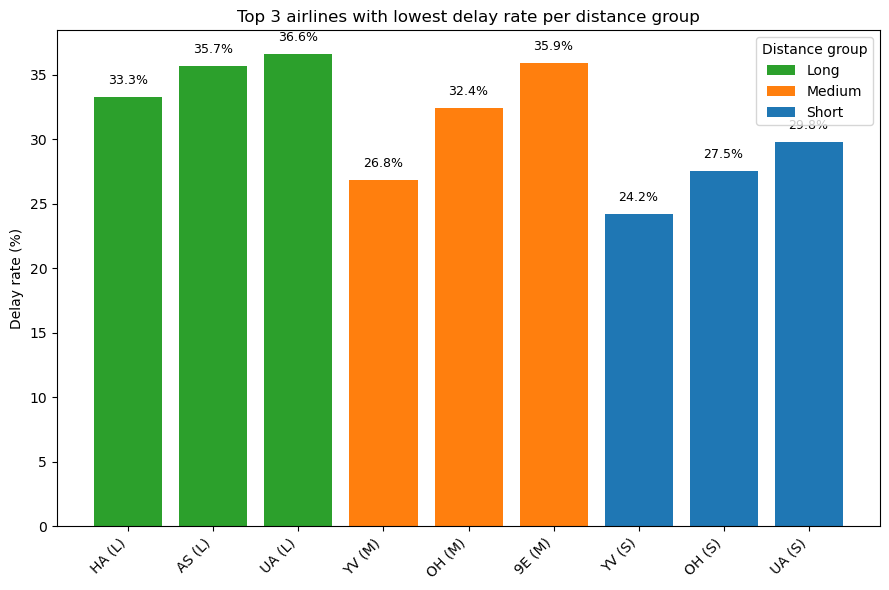

In [48]:
import matplotlib.pyplot as plt


top3_per_group = (
    airline_distance_stats
    .sort_values(["distance_group", "delay_rate"])
    .groupby("distance_group")
    .head(3)   
)

print(top3_per_group)


fig, ax = plt.subplots(figsize=(9,6))


colors = {"Short": "tab:blue", "Medium": "tab:orange", "Long": "tab:green"}

for group, subset in top3_per_group.groupby("distance_group"):
    ax.bar(
        subset["Airline"] + " (" + group[0] + ")",  
        subset["delay_pct"],
        color=colors[group],
        label=group
    )


for i, row in top3_per_group.iterrows():
    ax.text(
        row["Airline"] + " (" + row["distance_group"][0] + ")",
        row["delay_pct"] + 1,
        f"{row['delay_pct']:.1f}%",
        ha="center", fontsize=9
    )

ax.set_ylabel("Delay rate (%)")
ax.set_title("Top 3 airlines with lowest delay rate per distance group")
ax.legend(title="Distance group")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [49]:
# q3(d)

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df_long = df4[df4["Length"] > 360].copy()


df_long["DepHour"] = (df_long["Time"] // 60).astype(int)
bins = [0, 6, 12, 18, 24]
labels = ["0-6", "6-12", "12-18", "18-24"]
df_long["DepPeriod"] = pd.cut(df_long["DepHour"], bins=bins, labels=labels, right=False)


time_stats = (
    df_long.groupby("DepPeriod")["Delay"]
    .agg(delay_rate="mean", flights="count", delays="sum")
    .reset_index()
)
time_stats["delay_pct"] = (time_stats["delay_rate"] * 100).round(1)

print(time_stats)



  DepPeriod  delay_rate  flights  delays  delay_pct
0       0-6    0.548387       31      17       54.8
1      6-12    0.396849     2729    1083       39.7
2     12-18    0.507677     2019    1025       50.8
3     18-24    0.460366     1640     755       46.0


/var/folders/yn/zm7smhl10ms6jswr_nr6j0lm0000gn/T/ipykernel_61537/694648765.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long.groupby("DepPeriod")["Delay"]


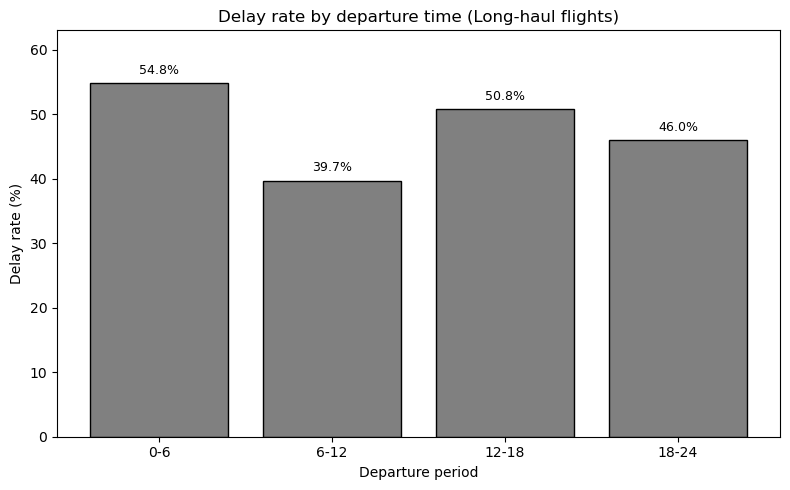

In [51]:

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(time_stats["DepPeriod"], time_stats["delay_pct"], color="grey", edgecolor="black")


for bar, pct in zip(bars, time_stats["delay_pct"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

ax.set_ylabel("Delay rate (%)")
ax.set_xlabel("Departure period")
ax.set_title("Delay rate by departure time (Long-haul flights)")
ax.set_ylim(0, max(time_stats["delay_pct"]) * 1.15)

plt.tight_layout()
plt.show()


In [52]:
# q4:

In [53]:
import pandas as pd
import matplotlib.pyplot as plt


hub_stats = (
    df4.groupby("hub_class_from")["Delay"]
      .agg(flights="count", delays="sum", delay_rate="mean")
      .reset_index()
)


hub_stats["delay_pct"] = (hub_stats["delay_rate"] * 100).round(1)


hub_stats = hub_stats[hub_stats["hub_class_from"].isin(["large hub", "medium hub"])]

print(hub_stats)


  hub_class_from  flights  delays  delay_rate  delay_pct
1      large hub   319222  147531    0.462158       46.2
2     medium hub   100306   49926    0.497737       49.8


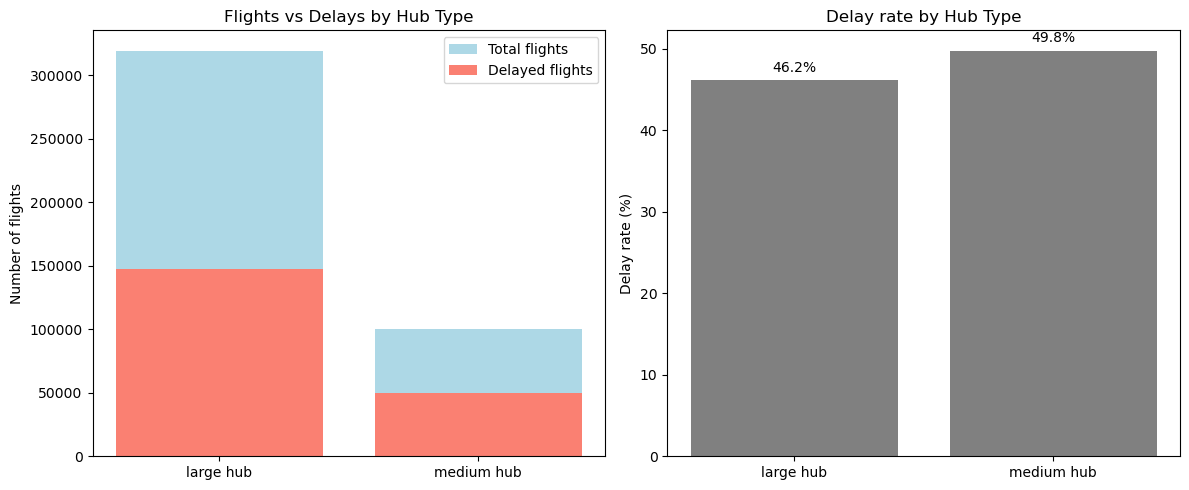

In [54]:

fig, ax = plt.subplots(1, 2, figsize=(12,5))


ax[0].bar(hub_stats["hub_class_from"], hub_stats["flights"], color="lightblue", label="Total flights")
ax[0].bar(hub_stats["hub_class_from"], hub_stats["delays"], color="salmon", label="Delayed flights")
ax[0].set_title("Flights vs Delays by Hub Type")
ax[0].set_ylabel("Number of flights")
ax[0].legend()


ax[1].bar(hub_stats["hub_class_from"], hub_stats["delay_pct"], color="gray")
for i, v in enumerate(hub_stats["delay_pct"]):
    ax[1].text(i, v+1, f"{v}%", ha="center", fontsize=10)
ax[1].set_title("Delay rate by Hub Type")
ax[1].set_ylabel("Delay rate (%)")

plt.tight_layout()
plt.show()

In [55]:
# q5(a)

In [56]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# === 0) copy a new data ===
df = fl4.copy()

# Delay are 0/1 
df["Delay"] = pd.to_numeric(df["Delay"], errors="coerce").fillna(0).astype(int)

# numeric
df["elevation_ft_from"] = pd.to_numeric(df["elevation_ft_from"], errors="coerce")

# only take 
d = df[["elevation_ft_from", "Delay"]].dropna().copy()

# === define low,medium and high===
# Low (0-500 ft), Medium (500-2000 ft), High (2000+ ft)
bins = [0, 500, 2000, np.inf]
labels = ["Low (0-500ft)", "Medium (500-2000ft)", "High (2000+ft)"]
d["alt_group_from"] = pd.cut(d["elevation_ft_from"], bins=bins, labels=labels, right=False)

# === 2) contigency table ===
cont = pd.crosstab(d["alt_group_from"], d["Delay"])  # 
print("Contingency table (Departure altitude group × Delay):")
print(cont)

# each group delay rate
delay_rate = (cont.get(1, 0) / cont.sum(axis=1) * 100).round(1)
print("\nDelay rate by departure altitude group (%):")
print(delay_rate)   

# === 3) chi-square test ===
chi2, p, dof, expected = chi2_contingency(cont)
print("\nChi-square test (Departure altitude):")

print(f"Chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

if p < 0.05:
    print("Conclusion (Departure): Reject H₀ → The altitude of the departure airport has a significant relationship with flight delays.")
else:
    print("Conclusion (Departure): Fail to reject H₀ → No significant relationship found between the departure airport altitude and flight delays.")


Contingency table (Departure altitude group × Delay):
Delay                     0       1
alt_group_from                     
Low (0-500ft)        136234  109095
Medium (500-2000ft)  116059   95025
High (2000+ft)        32225   29856

Delay rate by departure altitude group (%):
alt_group_from
Low (0-500ft)          44.5
Medium (500-2000ft)    45.0
High (2000+ft)         48.1
dtype: float64

Chi-square test (Departure altitude):
Chi2 = 264.34, dof = 2, p-value = 0.0000
Conclusion (Departure): Reject H₀ → The altitude of the departure airport has a significant relationship with flight delays.


In [57]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# === 1) data ===
d_to = df[["elevation_ft_to", "Delay"]].dropna().copy()

# === 2)（Low, Medium, High） ===
bins = [0, 500, 2000, np.inf]  
labels = ["Low (0-500ft)", "Medium (500-2000ft)", "High (2000+ft)"]
d_to["alt_group_to"] = pd.cut(d_to["elevation_ft_to"], bins=bins, labels=labels)

# === 3) contigency table ===
contingency_to = pd.crosstab(d_to["alt_group_to"], d_to["Delay"])
print("Contingency table (Arrival altitude group × Delay):")
print(contingency_to)

# === 4) delay rate ===
delay_rates_to = (contingency_to[1] / contingency_to.sum(axis=1) * 100).round(1)
print("\nDelay rate by arrival altitude group (%):")
print(delay_rates_to)

# === 5) chi-square ===
chi2, p, dof, expected = chi2_contingency(contingency_to)
print("\nChi-square test (Arrival altitude):")
print(f"Chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

if p < 0.05:
    print("Conclusion (Arrival): Reject H₀ → The altitude of the arrival airport has a significant relationship with flight delays.")
else:
    print("Conclusion (Arrival): Fail to reject H₀ → No significant relationship found between the altitude of the arrival airport and flight delays.")


Contingency table (Arrival altitude group × Delay):
Delay                     0       1
alt_group_to                       
Low (0-500ft)        132371  112932
Medium (500-2000ft)  120917   90174
High (2000+ft)        31252   30848

Delay rate by arrival altitude group (%):
alt_group_to
Low (0-500ft)          46.0
Medium (500-2000ft)    42.7
High (2000+ft)         49.7
dtype: float64

Chi-square test (Arrival altitude):
Chi2 = 1095.53, dof = 2, p-value = 0.0000
Conclusion (Arrival): Reject H₀ → The altitude of the arrival airport has a significant relationship with flight delays.


In [58]:
# 5(b)

In [59]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# === 1) select columns ===
d = df[["num_runways_from", "Delay"]].dropna().copy()

# === 2) divide different groups ===
bins = [0, 2, 5, np.inf]
labels = ["Small (0-2)", "Medium (3-5)", "Large (6+)"]
d["runway_group_from"] = pd.cut(d["num_runways_from"], bins=bins, labels=labels, right=True)

# === 3) build contigency table ===
contingency = pd.crosstab(d["runway_group_from"], d["Delay"])
print("Contingency table (Departure runways × Delay):")
print(contingency)

# === 4) chi square test ===
chi2, p, dof, expected = chi2_contingency(contingency)
print("\nChi-square Test (Departure runways):")
print(f"Chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

# === 5) resulr ===
if p < 0.05:
    print("Conclusion (Departure): Reject H₀ → The number of runways at the departure airport significantly affects flight delays.")
else:
    print("Conclusion (Departure): Fail to reject H₀ → No significant relationship found between departure airport runways and flight delays.")


Contingency table (Departure runways × Delay):
Delay                   0       1
runway_group_from                
Small (0-2)         49513   33044
Medium (3-5)       183583  159681
Large (6+)          51471   41264

Chi-square Test (Departure runways):
Chi2 = 1150.88, dof = 2, p-value = 0.0000
Conclusion (Departure): Reject H₀ → The number of runways at the departure airport significantly affects flight delays.


In [60]:
# ---- 0) copy 
df = fl4.copy()
df["Delay"] = pd.to_numeric(df["Delay"], errors="coerce").astype("Int64")

# ---- 1) select needed columns (arrival side)
d = df[["num_runways_to", "Delay"]].dropna().copy()

# ---- 2) categories: 0–2 / 3–5 / 6+

bins = [0, 3, 6, np.inf]
labels = ["Small (0–2)", "Medium (3–5)", "Large (6+)"]
d["runway_group_to"] = pd.cut(d["num_runways_to"], bins=bins, labels=labels, right=False)

# ---- 3) build contingency table: runway_group_to × Delay
contingency = pd.crosstab(d["runway_group_to"], d["Delay"])
print("Contingency table (Arrival runways × Delay):")
print(contingency)

# ---- 4) Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

print("\nChi-square Test (Arrival runways):")
print(f"Chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

# ---- 5) Conclusion
if p < 0.05:
    print("Conclusion (Arrival): Reject H₀ → The number of runways at the arrival airport significantly affects flight delays.")
else:
    print("Conclusion (Arrival): Fail to reject H₀ → No significant relationship found between arrival airport runways and flight delays.")


Contingency table (Arrival runways × Delay):
Delay                 0       1
runway_group_to                
Small (0–2)       44101   38459
Medium (3–5)     182874  160336
Large (6+)        57592   35194

Chi-square Test (Arrival runways):
Chi2 = 2361.62, dof = 2, p-value = 0.0000
Conclusion (Arrival): Reject H₀ → The number of runways at the arrival airport significantly affects flight delays.


In [61]:
#5 (c)

In [62]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# === 1) only select what we want ===
d = df[["hub_class_from", "Length", "Delay"]].dropna().copy()
d = d[d["hub_class_from"].isin(["large hub", "medium hub", "small/other"])]  # delete Unknown

# === 2) categorise flight length  ===
bins = [0, 180, 360, np.inf]
labels = ["Short (<180 min)", "Medium (180–360 min)", "Long (>360 min)"]
d["length_group"] = pd.cut(d["Length"], bins=bins, labels=labels, right=False)

# === 3) hub  ===
for hub in d["hub_class_from"].unique():
    print(f"\n=== Departure hub: {hub} ===")
    sub = d[d["hub_class_from"] == hub]

    contingency = pd.crosstab(sub["length_group"], sub["Delay"])
    print("Contingency table:")
    print(contingency)

    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

    if p < 0.05:
        print("Conclusion: Reject H₀ → Flight duration significantly affects delays at this departure hub.")
    else:
        print("Conclusion: Fail to reject H₀ → No significant relationship found between flight duration and delays at this departure hub.")



=== Departure hub: large hub ===
Contingency table:
Delay                      0       1
length_group                        
Short (<180 min)      134187  109382
Medium (180–360 min)   34317   35335
Long (>360 min)         3187    2814
Chi2 = 739.91, dof = 2, p-value = 0.0000
Conclusion: Reject H₀ → Flight duration significantly affects delays at this departure hub.

=== Departure hub: medium hub ===
Contingency table:
Delay                     0      1
length_group                      
Short (<180 min)      41697  41092
Medium (180–360 min)   8284   8616
Long (>360 min)         399    218
Chi2 = 61.99, dof = 2, p-value = 0.0000
Conclusion: Reject H₀ → Flight duration significantly affects delays at this departure hub.

=== Departure hub: small/other ===
Contingency table:
Delay                    0     1
length_group                    
Short (<180 min)      3885  3375
Medium (180–360 min)   235   297
Long (>360 min)          4     6
Chi2 = 18.02, dof = 2, p-value = 0.0001
Conclusi

In [63]:
# === 1) only select what we want ===
d = df[["hub_class_to", "Length", "Delay"]].dropna().copy()
d = d[d["hub_class_to"].isin(["large hub", "medium hub", "small/other"])]  # delete Unknown

# === 2) categorise flight length  ===
bins = [0, 180, 360, np.inf]
labels = ["Short (<180 min)", "Medium (180–360 min)", "Long (>360 min)"]
d["length_group"] = pd.cut(d["Length"], bins=bins, labels=labels, right=False)

for hub in d["hub_class_to"].unique():
    print(f"\n=== Arrival hub: {hub} ===")
    sub = d[d["hub_class_to"] == hub]

    contingency = pd.crosstab(sub["length_group"], sub["Delay"])
    print("Contingency table:")
    print(contingency)

    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

    if p < 0.05:
        print("Conclusion: Reject H₀ → Flight duration significantly affects delays at this arrival hub.")
    else:
        print("Conclusion: Fail to reject H₀ → No significant relationship found between flight duration and delays at this arrival hub.")



=== Arrival hub: large hub ===
Contingency table:
Delay                      0       1
length_group                        
Short (<180 min)      140401  101227
Medium (180–360 min)   37303   35649
Long (>360 min)         2601    2105
Chi2 = 1111.07, dof = 2, p-value = 0.0000
Conclusion: Reject H₀ → Flight duration significantly affects delays at this arrival hub.

=== Arrival hub: medium hub ===
Contingency table:
Delay                     0      1
length_group                      
Short (<180 min)      41080  42403
Medium (180–360 min)   6657   8387
Long (>360 min)         922    843
Chi2 = 135.38, dof = 2, p-value = 0.0000
Conclusion: Reject H₀ → Flight duration significantly affects delays at this arrival hub.

=== Arrival hub: small/other ===
Contingency table:
Delay                    0     1
length_group                    
Short (<180 min)      3341  3897
Medium (180–360 min)   219   368
Long (>360 min)          5     5
Chi2 = 17.23, dof = 2, p-value = 0.0002
Conclusion: Reje

In [64]:
# 6

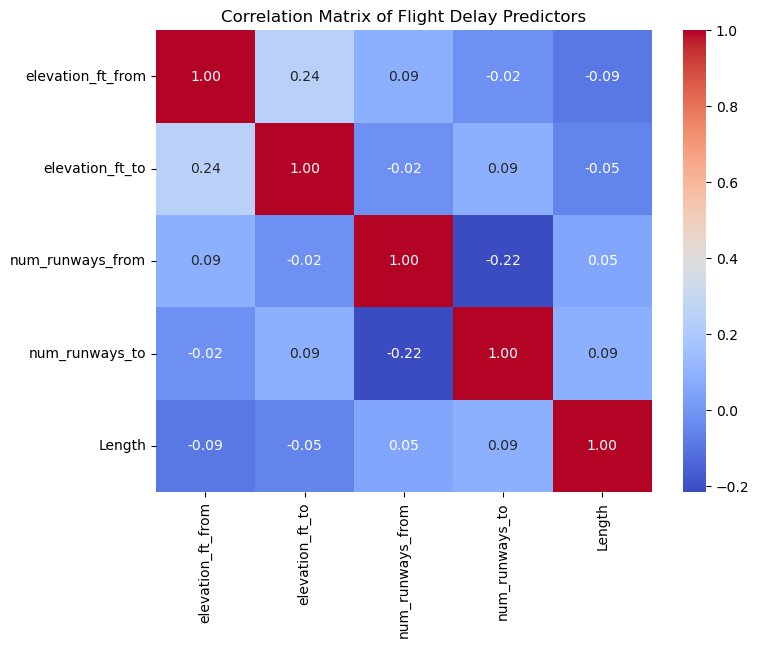

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# === 1) Select predictors (numerical columns only) ===
predictors = df[[
    "elevation_ft_from", 
    "elevation_ft_to", 
    "num_runways_from", 
    "num_runways_to", 
    "Length"
]]
# === 2) Compute correlation matrix ===
corr_matrix = predictors.corr()

# === 3) Plot heatmap ===
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Flight Delay Predictors")
plt.show()


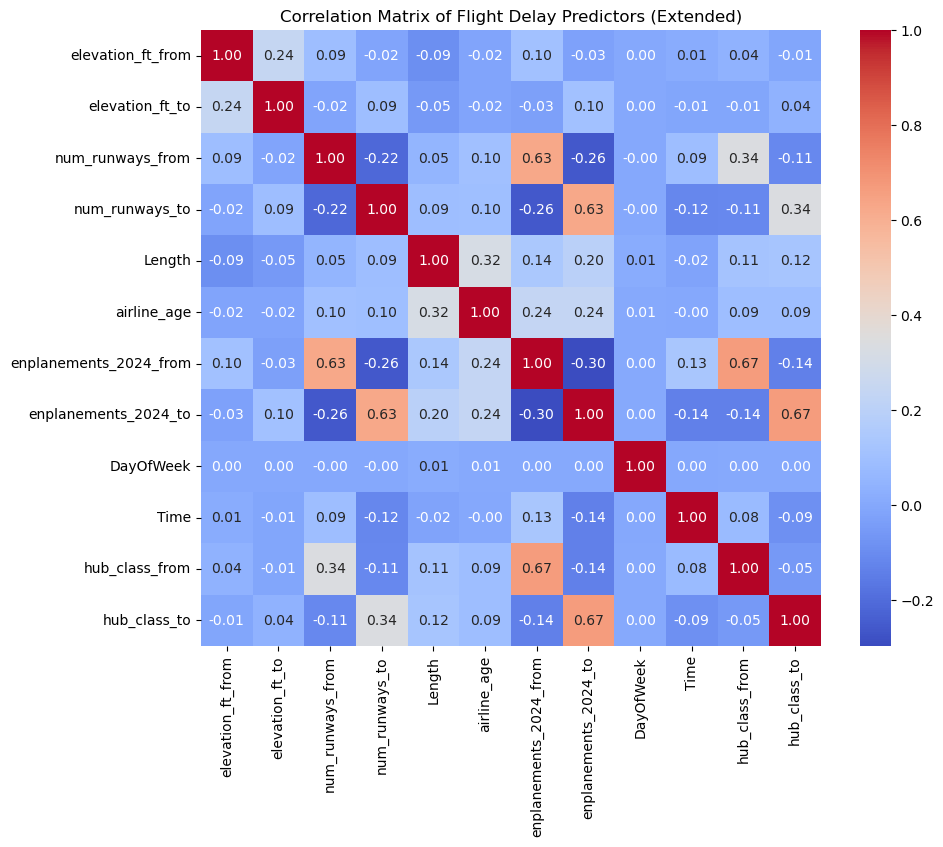

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1) Select relevant predictors ===
predictors = fl4[[
    "elevation_ft_from", "elevation_ft_to",
    "num_runways_from", "num_runways_to",
    "Length", 
    "airline_age",                # airline years of operation
    "enplanements_2024_from",     # passenger volume at departure airport
    "enplanements_2024_to",       # passenger volume at arrival airport
    "DayOfWeek",                  # day of week
    "Time"                        # departure time in minutes
]].copy()

# === 2) Encode categorical variables ===
# Example: encode hub_class (large=3, medium=2, small=1)
hub_map = {"large hub": 3, "medium hub": 2, "small/other": 1}
predictors["hub_class_from"] = df["hub_class_from"].map(hub_map)
predictors["hub_class_to"] = df["hub_class_to"].map(hub_map)

# === 3) Compute correlation matrix ===
corr_matrix = predictors.corr()

# === 4) Plot heatmap ===
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Flight Delay Predictors (Extended)")
plt.show()


In [67]:
# machine learning

In [68]:
# 1: data loading and initial check

In [69]:
# 1. find categorical type
print(fl4.dtypes)


categorical_vars = fl4.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical variables:", categorical_vars)


for col in categorical_vars:
    print(f"\nColumn: {col}")
    print(fl4[col].unique()[:10])  



id                          int64
Airline                    object
Flight                      int64
AirportFrom                object
AirportTo                  object
DayOfWeek                   int64
Time                        int64
Length                      int64
Delay                       int64
ident_from                 object
name_from                  object
type_from                  object
latitude_deg_from         float64
longitude_deg_from        float64
elevation_ft_from         float64
iso_country_from           object
iso_region_from            object
municipality_from          object
num_runways_from          float64
max_runway_len_ft_from    float64
avg_runway_len_ft_from    float64
avg_runway_wid_ft_from    float64
has_lighted_from          float64
num_closed_from           float64
has_closed_from           float64
main_surface_from          object
iata_code_from             object
gps_code_from              object
local_code_from            object
ident_to      

In [70]:
print("=" * 70)
print("type:", fl4.shape)
print("=" * 70)

type: (518556, 57)


In [71]:
# 2: feature engineering - create time features

def create_time_features(df):
    """from Time column - EDA analysis"""
    df = df.copy()
    df['Hour'] = (df['Time'] // 60).astype(int)  # hour
    # 
    bins = [0, 6, 12, 18, 24]
    labels = ["Night", "Morning", "Afternoon", "Evening"]  # 
    df['DepPeriod'] = pd.cut(df['Hour'], bins=bins, labels=labels, right=False)
    return df

fl4 = create_time_features(fl4)

fl4_test = create_time_features(fl4)
print(fl4_test[['Time', 'Hour', 'DepPeriod']].sample(15))


        Time  Hour  DepPeriod
500140  1080    18    Evening
35535    395     6    Morning
402828   440     7    Morning
335000   390     6    Morning
304359   629    10    Morning
325464   820    13  Afternoon
1442     419     6    Morning
200504   485     8    Morning
236299   590     9    Morning
399877  1090    18    Evening
132541  1335    22    Evening
11234    959    15  Afternoon
131648  1220    20    Evening
440602   745    12  Afternoon
466274  1175    19    Evening


In [72]:
#2.5 handling missing data
# Replace Unknown categorical values with smallest category
fl4['hub_class_from'] = fl4['hub_class_from'].replace('Unknown', 'small/other')
fl4['hub_class_to'] = fl4['hub_class_to'].replace('Unknown', 'small/other')
fl4['type_from'] = fl4['type_from'].replace('Unknown', 'small_airport')
fl4['type_to'] = fl4['type_to'].replace('Unknown', 'small_airport')

# handle missing value
airline_founded_years = {
    'CO': 1937,
    'US': 1937,
    'EV': 1986
}

for airline_code, founded_year in airline_founded_years.items():
    mask = (fl4['Airline'] == airline_code) & (fl4['airline_founded_year'].isna())
    fl4.loc[mask, 'airline_founded_year'] = founded_year
    fl4.loc[mask, 'airline_age'] = 2025 - founded_year

print(f"airline_founded_year missing: {fl4['airline_founded_year'].isna().sum()}")
#  show 0 missing!

airline_founded_year missing: 0


In [73]:
# 3: Define feature lists
# Features to drop (high cardinality or redundant)
print("\nCategorical feature cardinality:")
categorical_cols = fl4.select_dtypes(include=['object']).columns
for col in categorical_cols:
    n_unique = fl4[col].nunique()
    print(f"{col}: {n_unique} unique values")


drop_features = [
    'id',  # 
    'AirportFrom', 'AirportTo',  # 291
    'ident_from', 'ident_to',  # 291
    'name_from', 'name_to',  # 291
    'municipality_from', 'municipality_to',  # 280
    'iata_code_from', 'iata_code_to',  # 291
    'gps_code_from', 'gps_code_to',  # 291
    'local_code_from', 'local_code_to',  # 291
]
numerical_features = [
    'Flight', 'Length', 'Hour',  # 
    'latitude_deg_from', 'longitude_deg_from', 'elevation_ft_from',
    'num_runways_from', 'max_runway_len_ft_from', 
    'avg_runway_len_ft_from', 'avg_runway_wid_ft_from',
    'has_lighted_from', 'num_closed_from', 'has_closed_from',
    'latitude_deg_to', 'longitude_deg_to', 'elevation_ft_to',
    'num_runways_to', 'max_runway_len_ft_to',
    'avg_runway_len_ft_to', 'avg_runway_wid_ft_to',
    'has_lighted_to', 'num_closed_to', 'has_closed_to',
    'enplanements_2024_from', 'share_us_from',
    'enplanements_2024_to', 'share_us_to','airline_age'
]
# OneHotEncoder: no order
onehot_features = [
    'Airline',
    'main_surface_from', 'main_surface_to',
    'iso_country_from', 'iso_country_to',
    'iso_region_from', 'iso_region_to',
    'DepPeriod',  # departure time
    'DayOfWeek',  # 
]

# OrdinalEncoder: has order
ordinal_features = [
    'hub_class_from', 'hub_class_to', 'type_from', 'type_to',
]


Categorical feature cardinality:
Airline: 17 unique values
AirportFrom: 291 unique values
AirportTo: 291 unique values
ident_from: 291 unique values
name_from: 291 unique values
type_from: 3 unique values
iso_country_from: 5 unique values
iso_region_from: 54 unique values
municipality_from: 280 unique values
main_surface_from: 10 unique values
iata_code_from: 291 unique values
gps_code_from: 291 unique values
local_code_from: 291 unique values
ident_to: 291 unique values
name_to: 291 unique values
type_to: 3 unique values
iso_country_to: 5 unique values
iso_region_to: 54 unique values
municipality_to: 280 unique values
main_surface_to: 10 unique values
iata_code_to: 291 unique values
gps_code_to: 291 unique values
local_code_to: 291 unique values
hub_class_from: 3 unique values
hub_class_to: 3 unique values


In [74]:
# 
print(fl4['hub_class_from'].unique())

['large hub' 'medium hub' 'small/other']


In [75]:
print(fl4['type_from'].unique())

['large_airport' 'medium_airport' 'small_airport']


In [76]:
print("hub_class_from Unknown count:", (fl4['hub_class_from'] == 'Unknown').sum())
print("hub_class_to Unknown count:", (fl4['hub_class_to'] == 'Unknown').sum())

hub_class_from Unknown count: 0
hub_class_to Unknown count: 0


In [77]:
# 4. Prepare data (X and y)
# step 1: create  X, and Y

X = fl4.drop(columns=drop_features + ['Delay'], errors='ignore') # feature matrix, indenpendent variable
y = (fl4['Delay'] > 0).astype(int) # target variable, dependent variable

#count delay
print(f"\n{y.value_counts()}")
#delay rate
print(f"delay rate: {y.mean():.2%}")


#count how many numerical/onehot/ordinal in X
numerical_features = [f for f in numerical_features if f in X.columns]
onehot_features = [f for f in onehot_features if f in X.columns]
ordinal_features = [f for f in ordinal_features if f in X.columns]

print(f"Numerical features count: {len(numerical_features)}")
print(f"OneHot feature count: {len(onehot_features)}")
print(f"Ordinal feature count: {len(ordinal_features)}")


Delay
0    284567
1    233989
Name: count, dtype: int64
delay rate: 45.12%
Numerical features count: 28
OneHot feature count: 9
Ordinal feature count: 4


In [78]:
# 5. create preprocessing pipeline 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([  # num:- 
            ('imputer', SimpleImputer(strategy='median')),  # 
            ('scaler', StandardScaler())  
        ]), numerical_features),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         onehot_features),    
        ('ordinal', OrdinalEncoder(handle_unknown ='use_encoded_value', unknown_value= -1), 
         ordinal_features)  
    ],
    remainder='drop'
)

In [79]:
# 6. train-test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"train : {X_train.shape}")
print(f"test: {X_test.shape}")

train : (414844, 43)
test: (103712, 43)


In [80]:
# 7. Logistic Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
])

lr_pipeline.fit(X_train, y_train)

y_train_pred_lr = lr_pipeline.predict(X_train)
y_test_pred_lr = lr_pipeline.predict(X_test)

print("\n【Training Set Results】")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(classification_report(y_train, y_train_pred_lr))

print("\n【Test Set Results】")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_lr):.4f}")
print(classification_report(y_test, y_test_pred_lr))


【Training Set Results】
Accuracy: 0.6428
              precision    recall  f1-score   support

           0       0.65      0.76      0.70    227653
           1       0.63      0.50      0.56    187191

    accuracy                           0.64    414844
   macro avg       0.64      0.63      0.63    414844
weighted avg       0.64      0.64      0.64    414844


【Test Set Results】
Accuracy: 0.6393
              precision    recall  f1-score   support

           0       0.65      0.76      0.70     56914
           1       0.63      0.49      0.55     46798

    accuracy                           0.64    103712
   macro avg       0.64      0.63      0.63    103712
weighted avg       0.64      0.64      0.63    103712



In [81]:
# 8. Decision Tree (with Overfitting Analysis)

In [82]:
# First: Show overfitting without constraints

In [83]:
dt_overfit = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_overfit.fit(X_train, y_train)
y_train_pred_overfit = dt_overfit.predict(X_train)
y_test_pred_overfit = dt_overfit.predict(X_test)

print("\nWithout overfitting prevention:")
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred_overfit):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_overfit):.4f}")
print(f"Overfitting gap: {accuracy_score(y_train, y_train_pred_overfit) - accuracy_score(y_test, y_test_pred_overfit):.4f}")


Without overfitting prevention:
Training accuracy: 0.8171
Test accuracy: 0.6087
Overfitting gap: 0.2084


In [84]:
# Second: Apply overfitting prevention
print("\n【With Overfitting Prevention】")
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=50, 
                                         min_samples_leaf=20, random_state=42))
])

dt_pipeline.fit(X_train, y_train)
y_train_pred_dt = dt_pipeline.predict(X_train)
y_test_pred_dt = dt_pipeline.predict(X_test)

print("\nWith overfitting prevention (max_depth=10, min_samples_split=50, min_samples_leaf=20):")
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred_dt):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_dt):.4f}")
print(f"Overfitting gap: {accuracy_score(y_train, y_train_pred_dt) - accuracy_score(y_test, y_test_pred_dt):.4f}")

print("\n【Training Set Results】")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_dt):.4f}")
print(classification_report(y_train, y_train_pred_dt))

print("\n【Test Set Results】")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_dt):.4f}")
print(classification_report(y_test, y_test_pred_dt))


【With Overfitting Prevention】

With overfitting prevention (max_depth=10, min_samples_split=50, min_samples_leaf=20):
Training accuracy: 0.6561
Test accuracy: 0.6495
Overfitting gap: 0.0066

【Training Set Results】
Accuracy: 0.6561
              precision    recall  f1-score   support

           0       0.64      0.85      0.73    227653
           1       0.70      0.42      0.53    187191

    accuracy                           0.66    414844
   macro avg       0.67      0.64      0.63    414844
weighted avg       0.67      0.66      0.64    414844


【Test Set Results】
Accuracy: 0.6495
              precision    recall  f1-score   support

           0       0.64      0.84      0.73     56914
           1       0.68      0.41      0.52     46798

    accuracy                           0.65    103712
   macro avg       0.66      0.63      0.62    103712
weighted avg       0.66      0.65      0.63    103712



In [85]:
# 9. Gradient Boosting

In [86]:
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                             max_depth=5, random_state=42))
])

gb_pipeline.fit(X_train, y_train)

y_train_pred_gb = gb_pipeline.predict(X_train)
y_test_pred_gb = gb_pipeline.predict(X_test)

print("\n【Training Set Results】")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_gb):.4f}")
print(classification_report(y_train, y_train_pred_gb))

print("\n【Test Set Results】")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_gb):.4f}")
print(classification_report(y_test, y_test_pred_gb))


【Training Set Results】
Accuracy: 0.6634
              precision    recall  f1-score   support

           0       0.66      0.81      0.73    227653
           1       0.68      0.48      0.56    187191

    accuracy                           0.66    414844
   macro avg       0.67      0.65      0.64    414844
weighted avg       0.67      0.66      0.65    414844


【Test Set Results】
Accuracy: 0.6577
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     56914
           1       0.67      0.48      0.56     46798

    accuracy                           0.66    103712
   macro avg       0.66      0.64      0.64    103712
weighted avg       0.66      0.66      0.65    103712



In [87]:
# 10. Stratified 5-Fold Cross-Validation with Voting

In [88]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n--- Fold {fold} ---")
    
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train 3 models
    models = {
        'LR': Pipeline([('preprocessor', preprocessor), 
                       ('classifier', LogisticRegression(solver='saga', max_iter=1000, random_state=42))]),
        'DT': Pipeline([('preprocessor', preprocessor), 
                       ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=42))]),
        'GB': Pipeline([('preprocessor', preprocessor), 
                       ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))])
    }
    
    fold_preds = []
    for name, model in models.items():
        model.fit(X_fold_train, y_fold_train)
        pred = model.predict(X_fold_val)
        acc = accuracy_score(y_fold_val, pred)
        print(f"{name} Accuracy: {acc:.4f}")
        fold_preds.append(pred)
    
    # Majority Voting
    fold_preds = np.array(fold_preds)
    voting_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=fold_preds)
    voting_acc = accuracy_score(y_fold_val, voting_pred)
    print(f"Voting Accuracy: {voting_acc:.4f}")
    
    fold_results.append(voting_acc)

print(f"\nAverage Voting Accuracy: {np.mean(fold_results):.4f} (+/- {np.std(fold_results):.4f})")



--- Fold 1 ---
LR Accuracy: 0.6424
DT Accuracy: 0.6493
GB Accuracy: 0.6511
Voting Accuracy: 0.6515

--- Fold 2 ---
LR Accuracy: 0.6420
DT Accuracy: 0.6488
GB Accuracy: 0.6509
Voting Accuracy: 0.6513

--- Fold 3 ---
LR Accuracy: 0.6428
DT Accuracy: 0.6506
GB Accuracy: 0.6515
Voting Accuracy: 0.6517

--- Fold 4 ---
LR Accuracy: 0.6404
DT Accuracy: 0.6477
GB Accuracy: 0.6494
Voting Accuracy: 0.6501

--- Fold 5 ---
LR Accuracy: 0.6439
DT Accuracy: 0.6500
GB Accuracy: 0.6523
Voting Accuracy: 0.6531

Average Voting Accuracy: 0.6515 (+/- 0.0010)


In [89]:
# 11. Final Test Set Voting Prediction

In [90]:
final_models = {
    'LR': lr_pipeline,
    'DT': dt_pipeline,
    'GB': gb_pipeline
}

test_preds = []
for name, model in final_models.items():
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"{name} Test Accuracy: {acc:.4f}")
    test_preds.append(pred)

# Majority Voting
test_preds = np.array(test_preds)
final_voting_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=test_preds)
final_voting_acc = accuracy_score(y_test, final_voting_pred)

print(f"\nFinal Voting Test Accuracy: {final_voting_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_voting_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, final_voting_pred))

print("\n" + "=" * 70)
print("Complete!")
print("=" * 70)

LR Test Accuracy: 0.6394
DT Test Accuracy: 0.6494
GB Test Accuracy: 0.6578

Final Voting Test Accuracy: 0.6546

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.82      0.72     56914
           1       0.67      0.46      0.55     46798

    accuracy                           0.65    103712
   macro avg       0.66      0.64      0.63    103712
weighted avg       0.66      0.65      0.64    103712


Confusion Matrix:
[[46422 10492]
 [25328 21470]]

Complete!


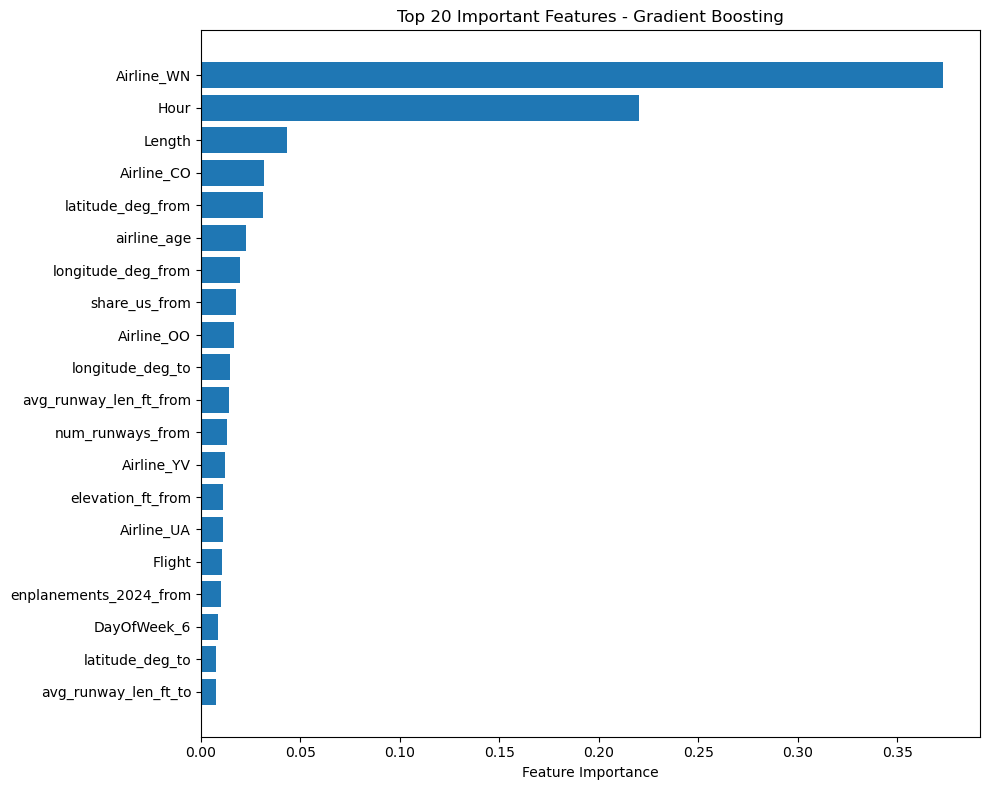

In [91]:
import matplotlib.pyplot as plt


gb_model = gb_pipeline.named_steps['classifier']


feature_names = (numerical_features + 
                list(gb_pipeline.named_steps['preprocessor']
                     .named_transformers_['onehot']
                     .get_feature_names_out(onehot_features)) +
                ordinal_features)

importances = gb_model.feature_importances_


indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features - Gradient Boosting')
plt.tight_layout()
plt.show()

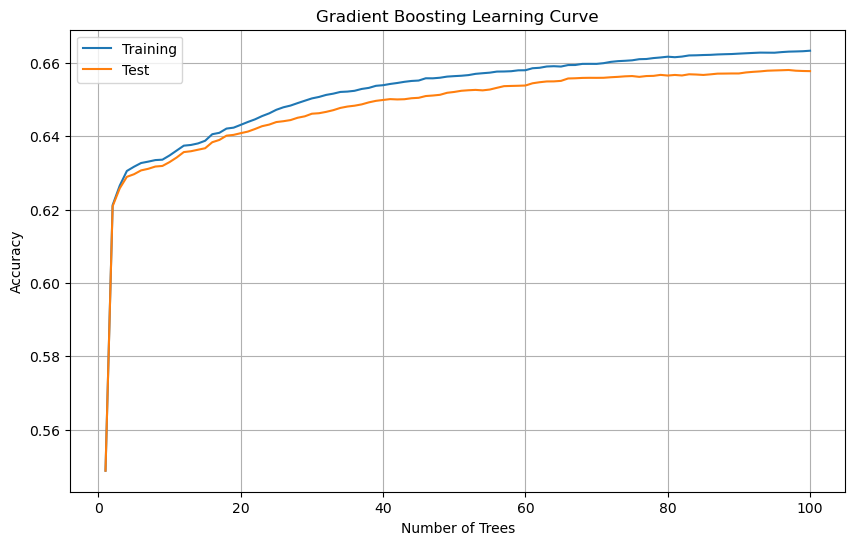

In [92]:

from sklearn.metrics import accuracy_score


train_scores = []
test_scores = []


X_train_prep = gb_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_prep = gb_pipeline.named_steps['preprocessor'].transform(X_test)

gb_model = gb_pipeline.named_steps['classifier']

for i, pred_train in enumerate(gb_model.staged_predict(X_train_prep)):
    train_scores.append(accuracy_score(y_train, pred_train))
    
for i, pred_test in enumerate(gb_model.staged_predict(X_test_prep)):
    test_scores.append(accuracy_score(y_test, pred_test))



plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_scores, label='Training')
plt.plot(range(1, 101), test_scores, label='Test')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
#3. Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#cm = confusion_matrix(y_test, y_test_pred_gb)


#plt.figure(figsize=(6, 5))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Gradient Boosting - Confusion Matrix')
#plt.show()

Confusion Matrix
[[45965 10949]
 [24550 22248]]


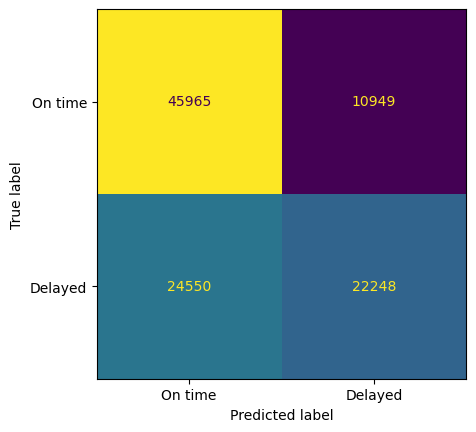

Classfication Report
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     56914
           1       0.67      0.48      0.56     46798

    accuracy                           0.66    103712
   macro avg       0.66      0.64      0.64    103712
weighted avg       0.66      0.66      0.65    103712



In [94]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, auc
conf_mat = confusion_matrix(y_test, y_test_pred_gb)
print('Confusion Matrix')
print(conf_mat)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = 
                                    ['On time','Delayed'])
cm_display.plot(colorbar = False)
plt.show()


print('Classfication Report')
print(classification_report(y_test, y_test_pred_gb))

In [95]:
# SQL

In [96]:
import sqlite3
import pandas as pd


conn = sqlite3.connect(':memory:')
fl4.to_sql('flights', conn, index=False, if_exists='replace')

query = """
SELECT 
    DayOfWeek,
    COUNT(*) as delayed_flights
FROM flights
WHERE Delay > 0
GROUP BY DayOfWeek
ORDER BY DayOfWeek;
"""

result = pd.read_sql_query(query, conn)
print(result)


   DayOfWeek  delayed_flights
0          1            33059
1          2            31072
2          3            41144
3          4            40280
4          5            34813
5          6            22860
6          7            30761


In [97]:


query = """
SELECT 
    Airline,
    COUNT(*) as delayed_flights
FROM flights
WHERE Delay > 0
GROUP BY Airline
ORDER BY delayed_flights DESC;
"""

result = pd.read_sql_query(query, conn)
print(result)



   Airline  delayed_flights
0       WN            65657
1       DL            27452
2       OO            22760
3       AA            17736
4       MQ            12742
5       CO            11957
6       XE            11795
7       US            11591
8       EV            11255
9       UA             8946
10      B6             8459
11      9E             8226
12      AS             3892
13      OH             3502
14      YV             3334
15      F9             2899
16      HA             1786


In [98]:
#question 3  Delayed flights landing at airports with at least 10 runways
query = """
SELECT 
    COUNT(*) as delayed_flights
FROM flights
WHERE Delay > 0 
AND num_runways_to >= 10;
"""

result = pd.read_sql_query(query, conn)
print("Question 3: Delayed flights landing at airports with at least 10 runways:")
print(result)


Question 3: Delayed flights landing at airports with at least 10 runways:
   delayed_flights
0             9295


In [99]:

#question 4:  Delayed flights by airport elevation (source and destination)
# SQL
query = """
WITH avg_elevation AS (
    SELECT 
        AVG(elevation_ft_from) as avg_elev_from,
        AVG(elevation_ft_to) as avg_elev_to
    FROM flights
)
SELECT 
    CASE 
        WHEN f.elevation_ft_from > ae.avg_elev_from AND f.elevation_ft_to > ae.avg_elev_to 
        THEN 'Both Above Average'
        WHEN f.elevation_ft_from < ae.avg_elev_from AND f.elevation_ft_to < ae.avg_elev_to 
        THEN 'Both Below Average'
        ELSE 'Mixed'
    END as elevation_category,
    COUNT(*) as delayed_flights
FROM flights f
CROSS JOIN avg_elevation ae
WHERE f.Delay > 0
GROUP BY elevation_category
ORDER BY delayed_flights DESC;
"""

result = pd.read_sql_query(query, conn)
print("Question 4: Delayed flights by airport elevation (source and destination):")
print(result)

conn.close()

Question 4: Delayed flights by airport elevation (source and destination):
   elevation_category  delayed_flights
0  Both Below Average           129435
1               Mixed            83289
2  Both Above Average            21265
